### **Import Dependencies**

In [12]:
# Standard library utilities
import json
from pathlib import Path
from typing import List, Dict, Tuple

# Third-party numerical & data packages
import numpy as np
import pandas as pd

# Medical imaging IO
import nibabel as nib

# Deep learning framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

# Layers for 3D architectures
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Input,
    Conv3D,
    BatchNormalization,
    Activation,
    MaxPooling3D,
    SpatialDropout3D,
    Conv3DTranspose,
    concatenate
)
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import Model

# Dataset utilities
from sklearn.model_selection import train_test_split

### **Preprocessing**

In [2]:
USE_FLOAT16 = True
MODALITIES = ["t1", "t1ce", "t2", "flair"]


def load_nifti_canonical(path: Path) -> Tuple[np.ndarray, np.ndarray, dict]:
    """Load NIfTI file in canonical orientation and extract minimal metadata."""
    nifti_obj = nib.load(str(path))
    nifti_canon = nib.as_closest_canonical(nifti_obj)

    vol = nifti_canon.get_fdata(dtype=np.float32)
    aff = nifti_canon.affine

    # Only store Header keys we actually care about
    keys = ["dim", "pixdim"]
    hdr_dict = {k: nifti_canon.header[k].tolist() if k in nifti_canon.header else None for k in keys}

    return vol, aff, hdr_dict


def normalize_nonzero(volume: np.ndarray) -> np.ndarray:
    """Z-score normalization but only over voxels that are non-zero."""
    casted = volume.astype(np.float32)
    nonzero_vals = casted[casted != 0]

    if nonzero_vals.size == 0:
        mu, sigma = float(casted.mean()), float(casted.std())
    else:
        mu, sigma = float(nonzero_vals.mean()), float(nonzero_vals.std())

    return (casted - mu) / (sigma + 1e-8)


def preprocess_mask_multiclass(mask: np.ndarray) -> np.ndarray:
    """Convert mask to integer classes and remap label 4 → 3."""
    out = np.rint(mask).astype(np.uint8)
    out[out == 4] = 3
    return out


def crop_to_roi(image: np.ndarray, mask: np.ndarray, margin: int = 5) -> Tuple[np.ndarray, np.ndarray]:
    """
    Crop the region-of-interest tightly around the mask.
    If mask has no foreground, return original.
    """
    coords = np.nonzero(mask)
    if np.array(coords).size == 0:
        return image, mask

    z_min, y_min, x_min = np.min(coords, axis=1)
    z_max, y_max, x_max = np.max(coords, axis=1)

    # Expand bounding box by margin safely
    z1 = max(z_min - margin, 0)
    y1 = max(y_min - margin, 0)
    x1 = max(x_min - margin, 0)

    z2 = min(z_max + margin, mask.shape[0] - 1)
    y2 = min(y_max + margin, mask.shape[1] - 1)
    x2 = min(x_max + margin, mask.shape[2] - 1)

    return (
        image[z1:z2 + 1, y1:y2 + 1, x1:x2 + 1],
        mask[z1:z2 + 1, y1:y2 + 1, x1:x2 + 1]
    )


def process_one_patient(patient_folder: Path, patient_id: str) -> Tuple[np.ndarray, np.ndarray, Dict]:
    """
    Load all modalities + mask for a single patient, verify alignment,
    crop ROI, normalize channels, collect minimal metadata.
    """
    # Load tumor mask
    mask_file = patient_folder / f"{patient_id}_seg.nii.gz"
    if not mask_file.exists():
        raise FileNotFoundError(f"Missing mask file: {mask_file}")

    mask_vol, aff_mask, hdr_mask = load_nifti_canonical(mask_file)
    mask = preprocess_mask_multiclass(mask_vol)

    # Prepare metadata container
    meta = {
        "patient_id": patient_id,
        "modalities": list(MODALITIES),
    }

    # Load modalities
    modality_volumes = []
    for m in MODALITIES:
        fpath = patient_folder / f"{patient_id}_{m}.nii.gz"
        if not fpath.exists():
            raise FileNotFoundError(f"Missing modality: {fpath}")

        vol, aff, hdr = load_nifti_canonical(fpath)
        modality_volumes.append(vol)

        # Store modality metadata
        meta[f"affine_{m}"] = aff.tolist()
        meta[f"header_{m}"] = hdr

    # Ensure all volumes are aligned
    vol_shapes = [v.shape for v in modality_volumes]
    if len(set(vol_shapes)) != 1:
        raise ValueError(
            f"Shape mismatch for patient {patient_id}: {vol_shapes}"
        )

    # Combine modalities into 4-channel tensor
    stacked = np.stack(modality_volumes, axis=-1)

    # Crop ROI
    stacked, mask = crop_to_roi(stacked, mask)

    # Per-channel normalization
    for ch in range(stacked.shape[-1]):
        stacked[..., ch] = normalize_nonzero(stacked[..., ch])

    # Optionally convert to float16
    if USE_FLOAT16:
        stacked = stacked.astype(np.float16)

    # Add mask metadata
    meta["affine_mask"] = aff_mask.tolist()
    meta["header_mask"] = hdr_mask
    meta["shape"] = list(mask.shape)

    return stacked, mask, meta


### **Data Generator**

In [3]:
import math

def pad_to_min_shape(arr, min_shape, pad_value=0):
    """
    Pad an array so its first 3 dimensions reach at least `min_shape`.
    Padding is symmetric.
    """
    pad_cfg = []
    for dim, current in enumerate(arr.shape[:3]):
        gap = max(0, min_shape[dim] - current)
        left = gap // 2
        right = gap - left
        pad_cfg.append((left, right))

    # Channel dimension untouched for 4D arrays
    if arr.ndim == 4:
        pad_cfg.append((0, 0))

    return np.pad(arr, pad_cfg, mode="constant", constant_values=pad_value)


def extract_patch(image, mask, patch_size, center=None):
    """
    Extract a 3D patch from `image` and `mask`.
    If the ROI is smaller than the patch, pad first.
    """
    H, W, D = image.shape[:3]
    pH, pW, pD = patch_size

    # Padding branch
    if H < pH or W < pW or D < pD:
        img_p = pad_to_min_shape(image, patch_size)
        msk_p = pad_to_min_shape(mask, patch_size)
        H2, W2, D2 = img_p.shape[:3]

        sy = (H2 - pH) // 2
        sx = (W2 - pW) // 2
        sz = (D2 - pD) // 2

        return (
            img_p[sy:sy+pH, sx:sx+pW, sz:sz+pD],
            msk_p[sy:sy+pH, sx:sx+pW, sz:sz+pD]
        )

    # Random or center-guided sampling
    if center is None:
        y0 = np.random.randint(0, H - pH + 1)
        x0 = np.random.randint(0, W - pW + 1)
        z0 = np.random.randint(0, D - pD + 1)
    else:
        cy, cx, cz = center
        y0 = np.clip(cy - pH // 2, 0, H - pH)
        x0 = np.clip(cx - pW // 2, 0, W - pW)
        z0 = np.clip(cz - pD // 2, 0, D - pD)

    return (
        image[y0:y0+pH, x0:x0+pW, z0:z0+pD],
        mask[y0:y0+pH, x0:x0+pW, z0:z0+pD]
    )


def random_flip_3d(img, msk):
    """
    Random 3-axis flipping augmentation.
    """
    for axis in (0, 1, 2):
        if np.random.rand() < 0.5:
            img = np.flip(img, axis=axis)
            msk = np.flip(msk, axis=axis)
    return img, msk


def intensity_jitter(img, shift_limit=0.1, scale_limit=0.1):
    """
    Light intensity scaling + shifting applied per channel.
    """
    out = img.astype(np.float32)
    channels = out.shape[-1]

    for c in range(channels):
        scale = 1.0 + np.random.uniform(-scale_limit, scale_limit)
        offset = np.random.uniform(-shift_limit, shift_limit)
        out[..., c] = out[..., c] * scale + offset

    return out


def add_noise(img, std=0.02):
    """
    Gaussian noise injection.
    """
    noise = np.random.normal(0, std, size=img.shape).astype(np.float32)
    return img + noise


class BraTSDataGenerator(keras.utils.Sequence):
    """
    Patch-wise data loader for BraTS segmentation.
    """

    def __init__(
        self,
        df,
        patch_size,
        batch_size=1,
        augment=False,
        shuffle=True,
        min_tumor_frac=0.01
    ):
        self.df = df.reset_index(drop=True)
        self.patch_size = tuple(patch_size)
        self.batch = batch_size
        self.do_aug = augment
        self.shuffle = shuffle
        self.min_tum = min_tumor_frac

        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        return len(self.df) // self.batch

    def on_epoch_end(self):
        self.idx_arr = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.idx_arr)

    def __getitem__(self, index):
        """
        Fetch one batch of (X, y) patches.
        """
        sel = self.idx_arr[index * self.batch : (index + 1) * self.batch]

        # Allocations
        X = np.zeros((self.batch, *self.patch_size, 4), dtype=np.float32)
        y = np.zeros((self.batch, *self.patch_size, 1), dtype=np.uint8)

        for ii, ridx in enumerate(sel):
            row = self.df.iloc[ridx]
            img = np.load(row["image_path"]).astype(np.float32)
            msk = np.load(row["mask_path"]).astype(np.uint8)

            # Patch extraction with tumor-priority logic
            attempts = 0
            patch_img = patch_msk = None

            while attempts < 10:
                tumor_vox = np.argwhere(msk > 0)

                if tumor_vox.size:
                    cy, cx, cz = tumor_vox[np.random.randint(0, len(tumor_vox))]
                    center = (cy, cx, cz)
                else:
                    center = None

                patch_img, patch_msk = extract_patch(img, msk, self.patch_size, center)
                frac = (patch_msk > 0).mean()

                # Acceptable tumor coverage or no tumor present
                if frac >= self.min_tum or tumor_vox.size == 0:
                    break

                attempts += 1

            # Optional augmentations
            if self.do_aug:
                patch_img, patch_msk = random_flip_3d(patch_img, patch_msk)

                if np.random.rand() < 0.5:
                    patch_img = intensity_jitter(patch_img)
                if np.random.rand() < 0.5:
                    patch_img = add_noise(patch_img)

            X[ii] = patch_img
            y[ii] = patch_msk[..., None]

        return X, y

### **Model Architecture**

In [4]:
def _conv_block(inp, filters, k=3, init="he_normal", reg=None):
    """
    Two-layer 3D convolution block with BN + ReLU.
    """
    x = layers.Conv3D(
        filters, k, padding="same",
        kernel_initializer=init,
        kernel_regularizer=reg
    )(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv3D(
        filters, k, padding="same",
        kernel_initializer=init,
        kernel_regularizer=reg
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x


def _decoder_step(latent, skip, filters, k=3, stride=2, init="he_normal", reg=None):
    """
    Up-sampling path: transposed convolution + skip connection + conv block.
    """
    up = layers.Conv3DTranspose(
        filters,
        k,
        strides=(stride, stride, stride),
        padding="same",
        kernel_initializer=init,
        kernel_regularizer=reg
    )(latent)

    merged = layers.concatenate([up, skip])
    return _conv_block(merged, filters, k, init, reg)


def create_advanced_3d_unet(input_shape, num_classes=4):
    """
    Construct an enhanced 3D U-Net architecture.
    """
    reg_term = regularizers.l2(1e-5)
    inp = Input(input_shape)

    # Encoder
    enc1 = _conv_block(inp, 32, reg=reg_term)
    down1 = layers.MaxPooling3D(2)(enc1)
    down1 = SpatialDropout3D(0.05)(down1)

    enc2 = _conv_block(down1, 64, reg=reg_term)
    down2 = layers.MaxPooling3D(2)(enc2)
    down2 = SpatialDropout3D(0.10)(down2)

    enc3 = _conv_block(down2, 128, reg=reg_term)
    down3 = layers.MaxPooling3D(2)(enc3)
    down3 = SpatialDropout3D(0.15)(down3)

    enc4 = _conv_block(down3, 256, reg=reg_term)
    down4 = layers.MaxPooling3D(2)(enc4)
    down4 = SpatialDropout3D(0.20)(down4)

    # Bottleneck
    bridge = _conv_block(down4, 512, reg=reg_term)

    # Decoder
    dec1 = _decoder_step(bridge, enc4, 256, reg=reg_term)
    dec2 = _decoder_step(dec1, enc3, 128, reg=reg_term)
    dec3 = _decoder_step(dec2, enc2, 64,  reg=reg_term)
    dec4 = _decoder_step(dec3, enc1, 32,  reg=reg_term)

    # Final segmentation layer
    out = layers.Conv3D(num_classes, 1, activation="softmax")(dec4)

    return Model(inp, out, name="Advanced_3D_UNet")

### **Loss Functions and Metrics**

In [5]:
SMOOTH = 1e-6

# ----------------------------------------------
# Dice coefficient
# ----------------------------------------------
def dice_coef(true_mask, pred_mask):
    flat_true = K.flatten(true_mask)
    flat_pred = K.flatten(pred_mask)
    overlap = K.sum(flat_true * flat_pred)

    return (2.0 * overlap + SMOOTH) / (
        K.sum(flat_true) + K.sum(flat_pred) + SMOOTH
    )


# ----------------------------------------------
# Dice loss (1 - Dice)
# ----------------------------------------------
def dice_loss(true_mask, pred_mask):
    return 1.0 - dice_coef(true_mask, pred_mask)


# ----------------------------------------------
# Intersection over Union (IoU)
# ----------------------------------------------
def iou_coef(y_true, y_pred, smooth=1e-6):
    # remove last channel if present
    squeezed_true = tf.squeeze(y_true, axis=-1)

    n_classes = K.int_shape(y_pred)[-1]

    # One-hot ground truth
    gt_onehot = tf.one_hot(tf.cast(squeezed_true, tf.int32), depth=n_classes)

    # Convert predicted probabilities to class index, then one-hot
    pred_labels = K.argmax(y_pred, axis=-1)
    pred_onehot = tf.one_hot(pred_labels, depth=n_classes)

    inter = K.sum(gt_onehot * pred_onehot, axis=[0, 1, 2, 3])
    union = K.sum(gt_onehot + pred_onehot, axis=[0, 1, 2, 3]) - inter

    return K.mean((inter + smooth) / (union + smooth))


# ----------------------------------------------
# Combined loss: Dice + Cross Entropy
# ----------------------------------------------
def combined_dice_ce_loss(y_true, y_pred):
    squeezed_true = tf.squeeze(y_true, axis=-1)
    total_classes = K.int_shape(y_pred)[-1]

    gt_oh = tf.one_hot(tf.cast(squeezed_true, tf.int32), depth=total_classes)

    # Average dice across all tumor classes except background (0)
    dice_total = 0.0
    for class_idx in range(1, total_classes):
        dice_total += dice_coef(gt_oh[..., class_idx], y_pred[..., class_idx])

    avg_dice = dice_total / tf.cast(total_classes - 1, tf.float32)

    # CE part
    ce_vals = K.categorical_crossentropy(gt_oh, y_pred)
    ce_mean = K.mean(ce_vals)

    # weighted combination
    return 0.5 * (1.0 - avg_dice) + 0.5 * ce_mean


# ----------------------------------------------
# Whole Tumor Dice
# ----------------------------------------------
def dice_whole_tumor(y_true, y_pred):
    squeezed_true = tf.squeeze(y_true, axis=-1)
    num_classes = K.int_shape(y_pred)[-1]

    y_true_oh = tf.one_hot(tf.cast(squeezed_true, tf.int32), depth=num_classes)
    pred_class = K.argmax(y_pred, axis=-1)

    # WT = union of ET, TC, edema → class labels {1,2,3}
    wt_true = K.cast(K.any(y_true_oh[..., 1:], axis=-1), "float32")

    wt_pred = K.cast(
        K.any(
            tf.stack(
                [
                    tf.equal(pred_class, 1),
                    tf.equal(pred_class, 2),
                    tf.equal(pred_class, 3),
                ],
                axis=-1,
            ),
            axis=-1,
        ),
        "float32",
    )

    return dice_coef(wt_true, wt_pred)


# ----------------------------------------------
# Tumor Core Dice
# ----------------------------------------------
def dice_tumor_core(y_true, y_pred):
    squeezed_true = tf.squeeze(y_true, axis=-1)
    num_classes = K.int_shape(y_pred)[-1]

    gt_oh = tf.one_hot(tf.cast(squeezed_true, tf.int32), depth=num_classes)
    pred_lbl = K.argmax(y_pred, axis=-1)

    # TC = classes {1, 3}
    tc_true = K.cast(K.any(tf.stack([gt_oh[..., 1], gt_oh[..., 3]], axis=-1), axis=-1), "float32")

    tc_pred = K.cast(
        K.any(
            tf.stack(
                [tf.equal(pred_lbl, 1), tf.equal(pred_lbl, 3)],
                axis=-1,
            ),
            axis=-1,
        ),
        "float32",
    )

    return dice_coef(tc_true, tc_pred)


# ----------------------------------------------
# Enhancing Tumor Dice
# ----------------------------------------------
def dice_enhancing_tumor(y_true, y_pred):
    squeezed_true = tf.squeeze(y_true, axis=-1)
    n_cls = K.int_shape(y_pred)[-1]

    true_oh = tf.one_hot(tf.cast(squeezed_true, tf.int32), depth=n_cls)
    pred_idx = K.argmax(y_pred, axis=-1)

    # ET = class 3
    true_et = true_oh[..., 3]
    pred_et = K.cast(tf.equal(pred_idx, 3), "float32")

    return dice_coef(true_et, pred_et)

In [6]:
from scipy.ndimage import distance_transform_edt, binary_erosion
import numpy as np

# ===============================================================
# Helper: compute bidirectional surface-to-surface distances
# ===============================================================
def compute_surface_distances(mask_true, mask_pred, voxel_spacing=(1.0, 1.0, 1.0)):
    """
    Calculate surface distances between a predicted binary mask
    and its ground truth counterpart.
    """

    # Identify surface voxels (boundary = volume XOR eroded volume)
    surf_true = mask_true.astype(bool) ^ binary_erosion(mask_true.astype(bool))
    surf_pred = mask_pred.astype(bool) ^ binary_erosion(mask_pred.astype(bool))

    # Extract coordinate lists for both surfaces
    pts_true = np.argwhere(surf_true)
    pts_pred = np.argwhere(surf_pred)

    # If no surfaces exist, distance is undefined → return infinities
    if pts_true.size == 0 or pts_pred.size == 0:
        return np.inf, np.inf

    # Distance transform of inverse surfaces
    dt_true = distance_transform_edt(~surf_true, sampling=voxel_spacing)
    dt_pred = distance_transform_edt(~surf_pred, sampling=voxel_spacing)

    # Distances: pred→true and true→pred
    dist_pred_to_true = dt_true[surf_pred]
    dist_true_to_pred = dt_pred[surf_true]

    return dist_pred_to_true, dist_true_to_pred


# ===============================================================
# HD95 computation
# ===============================================================
def hausdorff_distance_95(gt_mask, pred_mask, spacing_mm=(1.0, 1.0, 1.0)):
    """
    Compute the robust Hausdorff distance (95th percentile).
    """

    # Binarize masks
    gt_mask = (gt_mask > 0.5).astype(np.uint8)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    # Case 1: both masks empty → distance 0
    if gt_mask.sum() == 0 and pred_mask.sum() == 0:
        return 0.0

    # Case 2: one empty, one non-empty → undefined → infinite
    if gt_mask.sum() == 0 or pred_mask.sum() == 0:
        return np.inf

    # Compute distances
    dist_pred_to_gt, dist_gt_to_pred = compute_surface_distances(
        gt_mask, pred_mask, spacing_mm
    )

    # When infinite returned from compute_surface_distances()
    if isinstance(dist_pred_to_gt, float):
        return dist_pred_to_gt

    # Percentile distances
    hd95_p2g = np.percentile(dist_pred_to_gt, 95)
    hd95_g2p = np.percentile(dist_gt_to_pred, 95)

    return max(hd95_p2g, hd95_g2p)


# ===============================================================
# HD95 for the three tumor regions (WT, TC, ET)
# ===============================================================
def compute_hausdorff_for_sample(y_true, y_pred, spacing=(1.0, 1.0, 1.0)):
    """
    Compute HD95 for Whole Tumor, Tumor Core, and Enhancing Tumor.
    Accepts label maps or one-hot encoded maps.
    """

    # Convert one-hot → label volume if necessary
    if y_true.ndim == 4:
        gt_labels = np.argmax(y_true, axis=-1)
        pr_labels = np.argmax(y_pred, axis=-1)
    else:
        gt_labels = y_true
        pr_labels = y_pred

    hd_results = {}

    # ---------------------------
    # Whole Tumor (any class > 0)
    # ---------------------------
    wt_gt = (gt_labels > 0).astype(np.uint8)
    wt_pr = (pr_labels > 0).astype(np.uint8)
    hd_results["whole_tumor"] = hausdorff_distance_95(wt_gt, wt_pr, spacing)

    # ---------------------------
    # Tumor Core (class 1 or 3)
    # ---------------------------
    tc_gt = np.isin(gt_labels, [1, 3]).astype(np.uint8)
    tc_pr = np.isin(pr_labels, [1, 3]).astype(np.uint8)
    hd_results["tumor_core"] = hausdorff_distance_95(tc_gt, tc_pr, spacing)

    # ---------------------------
    # Enhancing Tumor (class 3)
    # ---------------------------
    et_gt = (gt_labels == 3).astype(np.uint8)
    et_pr = (pr_labels == 3).astype(np.uint8)
    hd_results["enhancing_tumor"] = hausdorff_distance_95(et_gt, et_pr, spacing)

    return hd_results

### **Data Loading, Splitting and Training**

In [9]:
import os

for root, dirs, files in os.walk("/kaggle/input", topdown=True):
    print(root)
    for f in files:
        print("   -", f)

/kaggle/input
   - BraTS2021_00495.tar
   - BraTS2021_Training_Data.tar
   - BraTS2021_00621.tar


In [10]:
import tarfile
from pathlib import Path

tar_path = '/kaggle/input/BraTS2021_Training_Data.tar'
extract_dir = '/kaggle/working/brats_dataset_2021'

# Extract
with tarfile.open(tar_path) as tar:
    tar.extractall(path=extract_dir)

DATA_DIR = Path(extract_dir)
print("Extracted to:", DATA_DIR)

Extracted to: /kaggle/working/brats_dataset_2021


In [13]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split

# ------------------- Initial Path Configuration -------------------
# Root folder after extraction
DATA_ROOT = Path('/kaggle/working/brats_dataset_2021')

# Directory for all processed .npy files and model artifacts
OUTPUT_DIR = Path('/kaggle/working/output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ------------------- Core Preprocessing Routine -------------------
def execute_preprocessing(data_root: Path, out_dir: Path) -> pd.DataFrame:
    """
    Iterates over all patient folders, processes each subject,
    and stores the results as .npy and metadata JSON files.
    """
    folders = [p for p in data_root.iterdir() if p.is_dir()]
    manifest_entries = []

    for folder in folders:
        patient = folder.name

        try:
            img, lbl, info = process_one_patient(folder, patient)

            img_out  = out_dir / f"{patient}_img.npy"
            msk_out  = out_dir / f"{patient}_msk.npy"
            meta_out = out_dir / f"{patient}_meta.json"

            np.save(img_out, img)
            np.save(msk_out, lbl)
            with open(meta_out, "w") as fp:
                json.dump(info, fp)

            manifest_entries.append({
                "patient_id": patient,
                "image_path": str(img_out),
                "mask_path": str(msk_out),
                "meta_path": str(meta_out)
            })

        except Exception as err:
            print(f"[Warning] Failed on {patient}: {err}")

    return pd.DataFrame(manifest_entries)


# ------------------- Manifest Handling -------------------
manifest_path = OUTPUT_DIR / "manifest.csv"

if not manifest_path.exists():
    print("• Preprocessing stage initiated ...")
    df = execute_preprocessing(DATA_ROOT, OUTPUT_DIR)
    df.to_csv(manifest_path, index=False)
else:
    print("• Manifest detected — loading cached metadata.")
    df = pd.read_csv(manifest_path)

print(f"Subjects discovered: {len(df)}")

# ------------------- Dataset Partitioning -------------------
train_df, remaining = train_test_split(df, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(remaining, test_size=0.5, shuffle=True, random_state=42)

print(f"Training: {len(train_df)}, Validation: {len(val_df)}, Testing: {len(test_df)}")

train, val, test = train_df, val_df, test_df

# ------------------- Patch & Model Parameters -------------------
PATCH_DIMS  = (96, 96, 96)
BATCH_SZ    = 1
N_CLASSES   = 4
EPOCH_COUNT = 10

# ------------------- Generators -------------------
train_gen = BraTSDataGenerator(
    train,
    patch_size=PATCH_DIMS,
    batch_size=BATCH_SZ,
    augment=True,
    shuffle=True
)

val_gen = BraTSDataGenerator(
    val,
    patch_size=PATCH_DIMS,
    batch_size=BATCH_SZ,
    augment=False,
    shuffle=False
)

# ------------------- Model Initialization -------------------
model = create_advanced_3d_unet(
    input_shape=(*PATCH_DIMS, 4),
    num_classes=N_CLASSES
)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=combined_dice_ce_loss,
    metrics=[
        dice_whole_tumor,
        dice_tumor_core,
        dice_enhancing_tumor,
        iou_coef
    ]
)

# ------------------- Callbacks -------------------
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop_cb = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=20,
    restore_best_weights=True
)

checkpoint_cb = ModelCheckpoint(
    filepath=str(OUTPUT_DIR / 'model/Unet_model.keras'),
    monitor="val_dice_whole_tumor",
    mode="max",
    save_best_only=True,
    verbose=1
)

lr_reduce_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=8,
    min_lr=3e-4,
    verbose=1
)

callbacks = [early_stop_cb, checkpoint_cb, lr_reduce_cb]

• Manifest detected — loading cached metadata.
Subjects discovered: 1251
Training: 875, Validation: 188, Testing: 188


I0000 00:00:1763321668.098012      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763321668.099507      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


### **Train the Model**

In [15]:
# --- Training Loop ---------------------------------------------------------
training_history = model.fit(
    x=train_gen,
    validation_data=val_gen,
    epochs=EPOCH_COUNT,
    callbacks=callbacks_list if 'callbacks_list' in locals() else callbacks,
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1763321709.577489     146 service.cc:148] XLA service 0x7837d8004490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763321709.578910     146 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763321709.578929     146 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763321711.723895     146 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-16 19:35:31.326130: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3,3]{4,3,2

875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - dice_enhancing_tumor: 0.4771 - dice_tumor_core: 0.5355 - dice_whole_tumor: 0.7099 - iou_coef: 0.4700 - loss: 0.8857
Epoch 1: val_dice_whole_tumor improved from -inf to 0.87954, saving model to /kaggle/working/output/model/Unet_model.keras
875/875 ━━━━━━━━━━━━━━━━━━━━ 717s 756ms/step - dice_enhancing_tumor: 0.4773 - dice_tumor_core: 0.5357 - dice_whole_tumor: 0.7100 - iou_coef: 0.4701 - loss: 0.8854 - val_dice_enhancing_tumor: 0.7064 - val_dice_tumor_core: 0.7457 - val_dice_whole_tumor: 0.8795 - val_iou_coef: 0.6412 - val_loss: 0.5344 - learning_rate: 1.0000e-04
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - dice_enhancing_tumor: 0.7185 - dice_tumor_core: 0.7560 - dice_whole_tumor: 0.8836 - iou_coef: 0.6626 - loss: 0.4615
Epoch 2: val_dice_whole_tumor improved from 0.87954 to 0.89801, saving model to /kaggle/working/output/model/Unet_model.keras
875/875 ━━━━━━━━━━━━━━━━━━━━ 661s 755ms/step - dice_enhancing_tumor: 0.7186 - dice_tumor_

### **Model Evaluation: DICE SCORE & HAUSDORFF DISTANCE**

In [18]:
import numpy as np
import pandas as pd
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import binary_erosion

print("Loading model...")
test_gen = BraTSDataGenerator(test, patch_size=PATCH_DIMS, batch_size=1, augment=False, shuffle=False)

best_model = keras.models.load_model(
    str(OUTPUT_DIR / 'model/Unet_model.keras'),
    custom_objects={
        'combined_dice_ce_loss': combined_dice_ce_loss,
        'dice_whole_tumor': dice_whole_tumor,
        'dice_tumor_core': dice_tumor_core,
        'dice_enhancing_tumor': dice_enhancing_tumor,
        'iou_coef': iou_coef
    }
)
print("Model loaded.\n")

# --- Dice Scores ---
print("Evaluating Dice scores on test set...")
scores = best_model.evaluate(test_gen, verbose=0)

dice_results = {
    'Whole Tumor': scores[1],
    'Tumor Core': scores[2],
    'Enhancing Tumor': scores[3]
}

print("\nDice Scores:")
for region, value in dice_results.items():
    print(f"  {region}: {value:.4f}")

# --- Hausdorff Distances ---
print("\nComputing HD95 (this may take time)...")

hd_whole_tumor = []
hd_tumor_core = []
hd_enhancing_tumor = []

for i in range(len(test)):
    try:
        full_image = np.load(test.iloc[i]['image_path'])
        full_mask_gt = np.load(test.iloc[i]['mask_path'])

        h, w, d, c = full_image.shape
        pred_mask_full = np.zeros((h, w, d, 4), dtype=np.float32)
        pred_count = np.zeros((h, w, d, 1), dtype=np.float32)

        patch_size = PATCH_DIMS[0]
        stride = patch_size // 2

        for z in range(0, max(1, d - patch_size + 1), stride):
            for y in range(0, max(1, h - patch_size + 1), stride):
                for x in range(0, max(1, w - patch_size + 1), stride):
                    z_end = min(z + patch_size, d)
                    y_end = min(y + patch_size, h)
                    x_end = min(x + patch_size, w)

                    z_start = max(0, z_end - patch_size)
                    y_start = max(0, y_end - patch_size)
                    x_start = max(0, x_end - patch_size)

                    patch = full_image[y_start:y_end, x_start:x_end, z_start:z_end, :]

                    if patch.shape[:3] != (patch_size, patch_size, patch_size):
                        padded = np.zeros((patch_size, patch_size, patch_size, 4), dtype=np.float32)
                        padded[:patch.shape[0], :patch.shape[1], :patch.shape[2], :] = patch
                        patch = padded

                    pred_patch = best_model.predict(np.expand_dims(patch, axis=0), verbose=0)[0]

                    actual_h = min(patch_size, y_end - y_start)
                    actual_w = min(patch_size, x_end - x_start)
                    actual_d = min(patch_size, z_end - z_start)

                    pred_mask_full[y_start:y_end, x_start:x_end, z_start:z_end, :] += \
                        pred_patch[:actual_h, :actual_w, :actual_d, :]

                    pred_count[y_start:y_end, x_start:x_end, z_start:z_end, :] += 1

        pred_mask_full /= np.maximum(pred_count, 1)
        pred_labels = np.argmax(pred_mask_full, axis=-1)

        hd = compute_hausdorff_for_sample(full_mask_gt, pred_labels, spacing=(1, 1, 1))

        if np.isfinite(hd['whole_tumor']):
            hd_whole_tumor.append(hd['whole_tumor'])
        if np.isfinite(hd['tumor_core']):
            hd_tumor_core.append(hd['tumor_core'])
        if np.isfinite(hd['enhancing_tumor']):
            hd_enhancing_tumor.append(hd['enhancing_tumor'])

    except Exception as e:
        print(f"Error on sample {i+1}: {str(e)}")

print("\nHD95 Results:")
print(f"  Whole Tumor:     {np.mean(hd_whole_tumor):.2f} mm")
print(f"  Tumor Core:       {np.mean(hd_tumor_core):.2f} mm")
print(f"  Enhancing Tumor:  {np.mean(hd_enhancing_tumor):.2f} mm")

# --- Summary ---
print("\nSummary:")
print(f"  Dice (WT): {dice_results['Whole Tumor']:.4f}")
print(f"  Dice (TC): {dice_results['Tumor Core']:.4f}")
print(f"  Dice (ET): {dice_results['Enhancing Tumor']:.4f}")

print(f"  HD95 (WT): {np.mean(hd_whole_tumor):.2f} mm")
print(f"  HD95 (TC): {np.mean(hd_tumor_core):.2f} mm")
print(f"  HD95 (ET): {np.mean(hd_enhancing_tumor):.2f} mm")

print("\nDone.")

Loading model...
Model loaded.

Evaluating Dice scores on test set...

Dice Scores:
  Whole Tumor: 0.9086
  Tumor Core: 0.8516
  Enhancing Tumor: 0.8143

Computing HD95 (this may take time)...

HD95 Results:
  Whole Tumor:     7.14 mm
  Tumor Core:       6.05 mm
  Enhancing Tumor:  5.03 mm

Summary:
  Dice (WT): 0.9086
  Dice (TC): 0.8516
  Dice (ET): 0.8143
  HD95 (WT): 7.14 mm
  HD95 (TC): 6.05 mm
  HD95 (ET): 5.03 mm

Done.


### **3D Visualization**

Visualizing sample 1


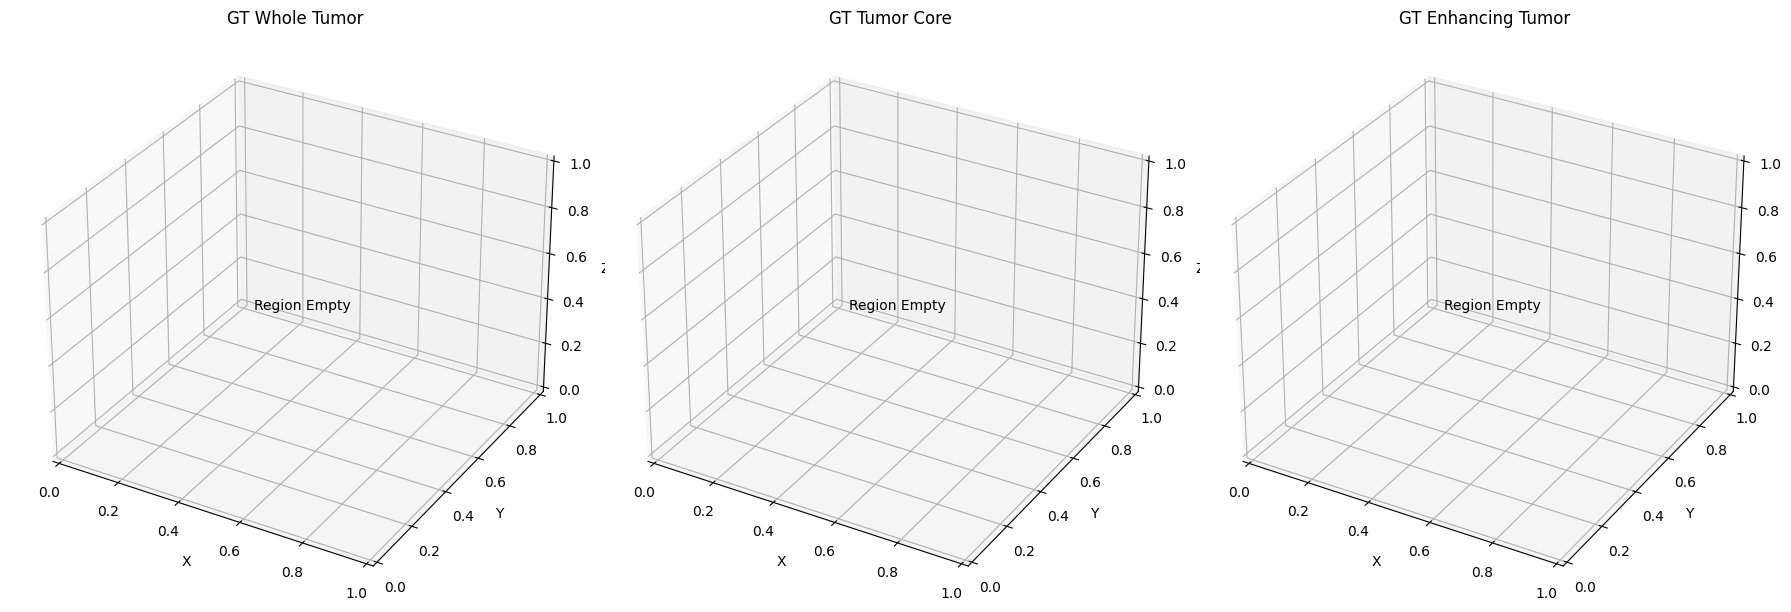

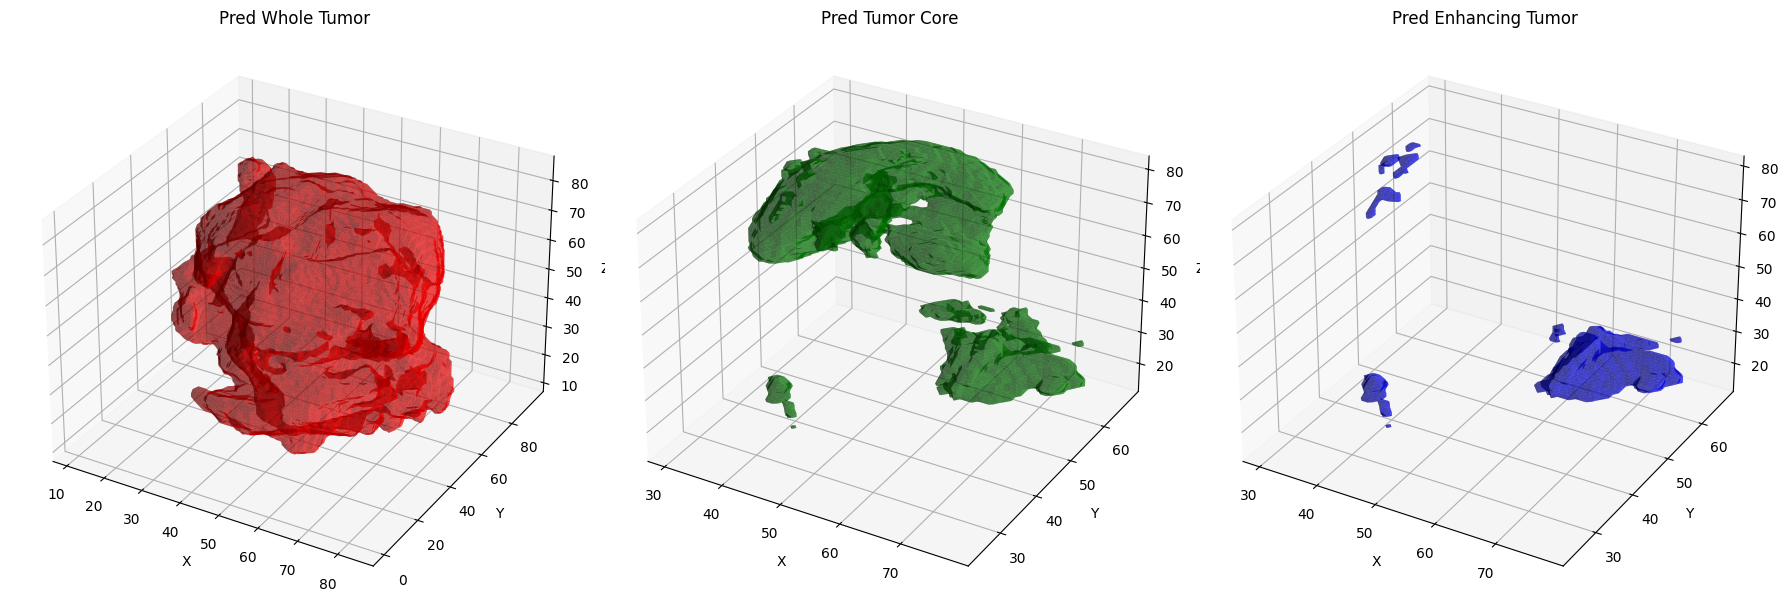

Saved GT and Prediction for sample 1
Visualizing sample 2


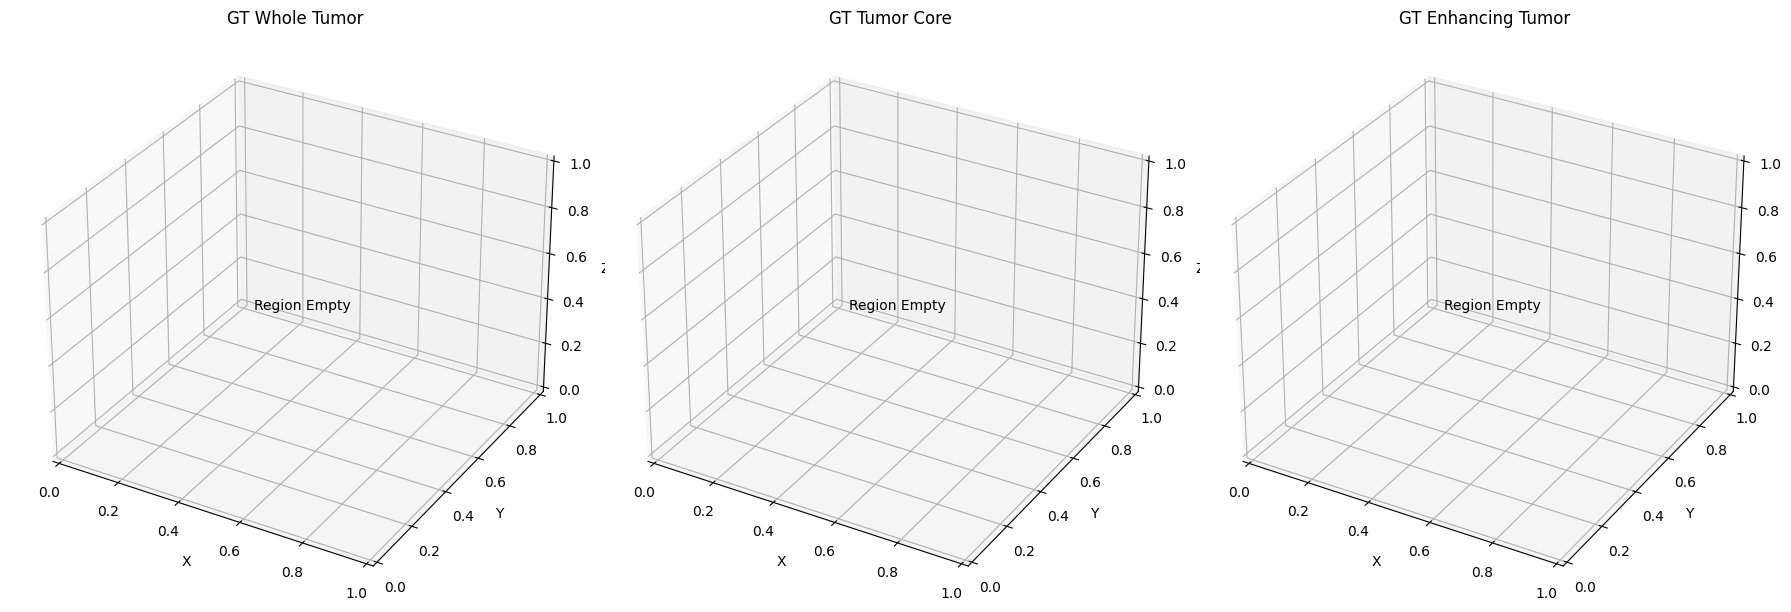

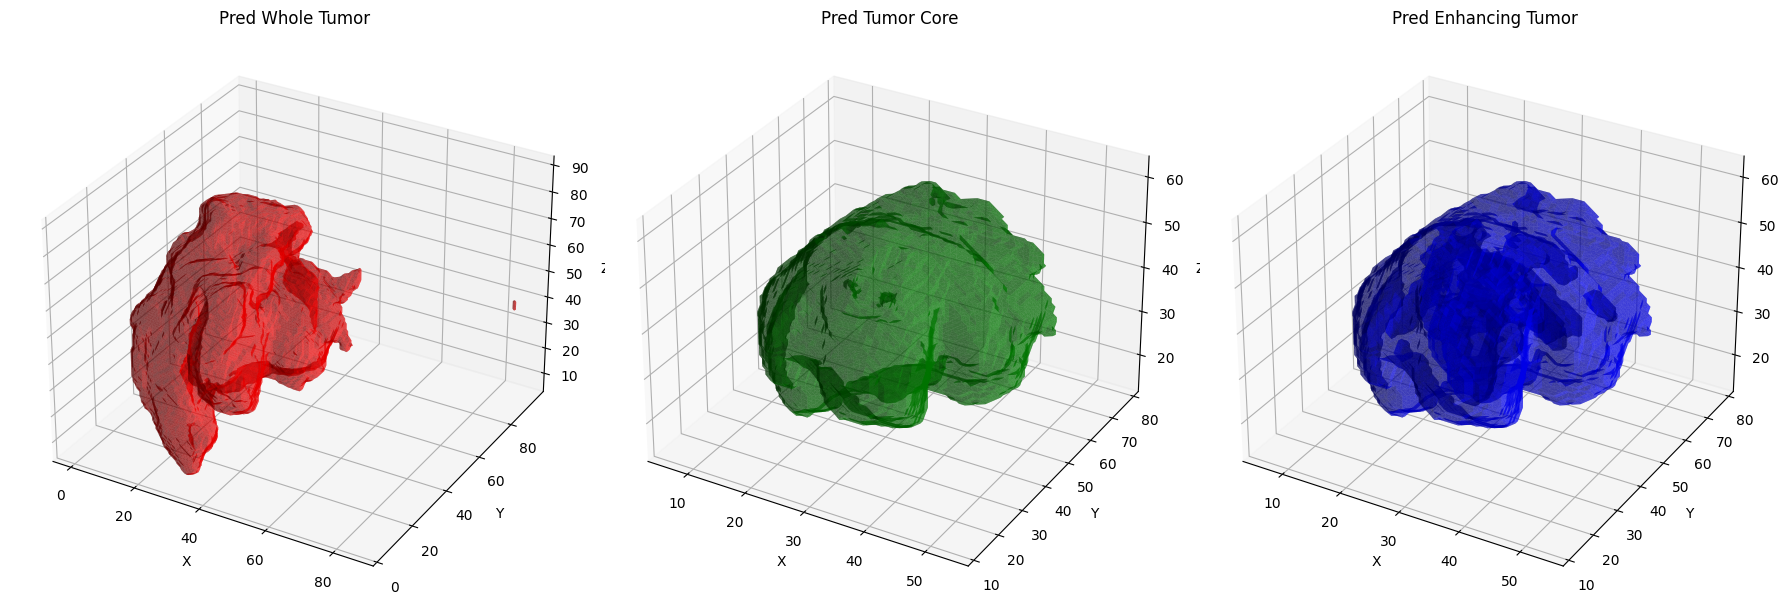

Saved GT and Prediction for sample 2
Visualizing sample 3


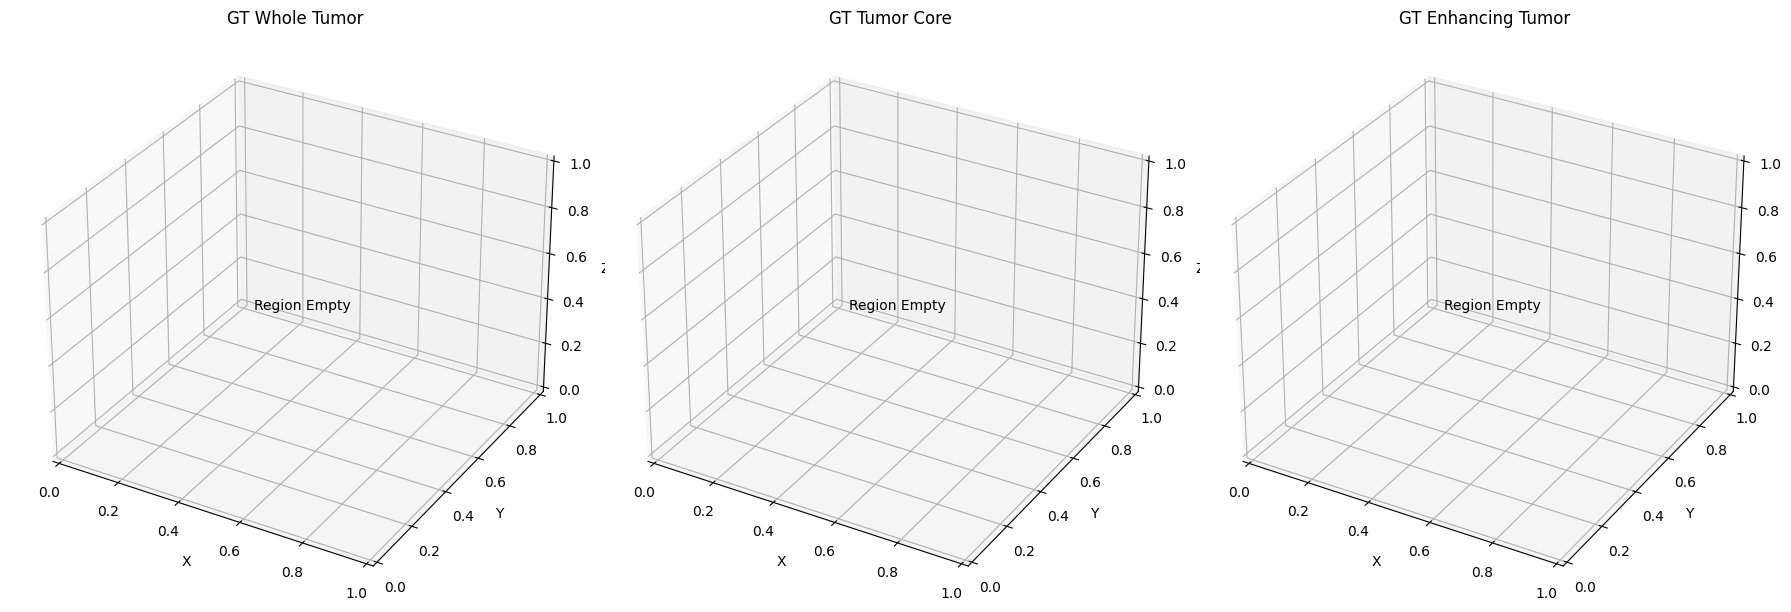

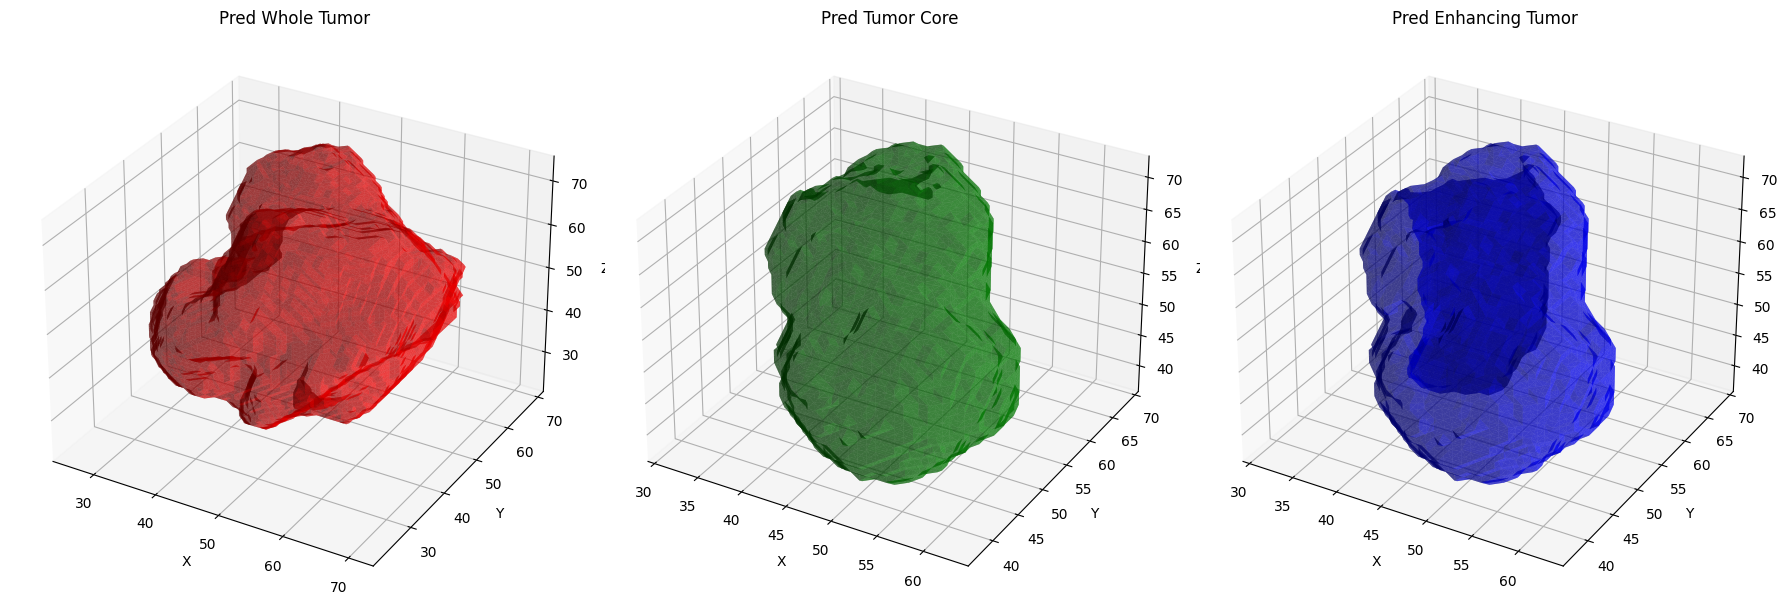

Saved GT and Prediction for sample 3


In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
import numpy as np

# ---------- Utility Functions ----------

def render_3d_volume(volume, threshold=0.5, color='red', alpha=0.3):
    volume_binary = (volume > threshold).astype(np.uint8)
    if np.sum(volume_binary) == 0:
        print("Empty volume — skipping.")
        return None
    
    try:
        verts, faces, normals, values = measure.marching_cubes(volume_binary, level=0.5)
    except:
        print("Marching cube failed — skipping.")
        return None
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_trisurf(
        verts[:, 0], verts[:, 1], faces, verts[:, 2],
        color=color, alpha=alpha, linewidth=0.2
    )

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    max_range = np.array([
        verts[:, 0].max() - verts[:, 0].min(),
        verts[:, 1].max() - verts[:, 1].min(),
        verts[:, 2].max() - verts[:, 2].min()
    ]).max() / 2.0

    mid_x = (verts[:, 0].max() + verts[:, 0].min()) * 0.5
    mid_y = (verts[:, 1].max() + verts[:, 1].min()) * 0.5
    mid_z = (verts[:, 2].max() + verts[:, 2].min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    return fig


def plot_3d_tumor_regions(mask_3d, title_prefix=""):
    if len(mask_3d.shape) == 4:
        labels_3d = np.argmax(mask_3d, axis=-1)
    else:
        labels_3d = mask_3d

    whole_tumor = (labels_3d > 0).astype(np.uint8)
    tumor_core = np.isin(labels_3d, [1, 3]).astype(np.uint8)
    enhancing_tumor = (labels_3d == 3).astype(np.uint8)

    fig = plt.figure(figsize=(18, 6))

    regions = [
        (whole_tumor, "Whole Tumor", "red"),
        (tumor_core, "Tumor Core", "green"),
        (enhancing_tumor, "Enhancing Tumor", "blue")
    ]

    for i, (mask, name, col) in enumerate(regions, 1):
        ax = fig.add_subplot(1, 3, i, projection='3d')
        if np.sum(mask) > 100:
            try:
                verts, faces, _, _ = measure.marching_cubes(mask, level=0.5)
                ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                                color=col, alpha=0.5, linewidth=0)
            except:
                ax.text(0.5, 0.5, 0.5, 'Error rendering', ha='center')
        else:
            ax.text(0.5, 0.5, 0.5, 'Region Empty', ha='center')

        ax.set_title(f"{title_prefix} {name}")
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

    plt.tight_layout()
    return fig


# ---------- Visualization Loop ----------

num_viz_samples = 3

for idx in range(min(num_viz_samples, len(test))):
    print(f"Visualizing sample {idx+1}")

    sample_image, sample_mask = test_gen[idx]
    pred_mask = best_model.predict(sample_image, verbose=0)

    # Ground Truth
    fig_gt = plot_3d_tumor_regions(sample_mask[0], title_prefix="GT")
    plt.savefig(f'gt_sample_{idx+1}.png', dpi=100)
    plt.show()

    # Prediction
    fig_pred = plot_3d_tumor_regions(pred_mask[0], title_prefix="Pred")
    plt.savefig(f'pred_sample_{idx+1}.png', dpi=100)
    plt.show()

    print(f"Saved GT and Prediction for sample {idx+1}")